In [ ]:
# install yfinance
!pip install yfinance --upgrade --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 17.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [59]:
stocks = ["LULU",  "MNST", "AAPL", "GOOG", "AMZN", "MA", "JPM", "NVDA"]
stocks = ["LULU",  "MNST", "AAPL"]
stocks = ['HZNP', 'POWWP', 'ALFIW', 'GNTY', 'PRTS', 'MCAFR', 'BCSA', 'PRTG']
colors = ['blue', 'green', 'red']

# download historical data
df = [yf.download(stock, period = "2y", interval = "1mo")[["Adj Close"]] for stock in stocks]
for i in range(len(stocks)):
  df[i] = df[i].rename({"Adj Close": stocks[i]}, axis=1)
df = pd.concat(df, axis=1)
print(df.head())
df = df.dropna()

# calculate daily % returns
stock_ret = df.pct_change()
stock_ret = stock_ret.dropna()
print(stock_ret.head())

for s in stocks:
  df[s + "_diff"] = (df[s].diff())
  #df[s + "_return"] = df[s]
df = df.dropna()
print(df[[s+"_diff" for s in stocks]].head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                                HZNP  POWWP  ALFIW       GNTY   PRTS  MCAFR  \
Date                                                                          
2020-11-01 00:00:00-04:00  70.430000    NaN    NaN  27.461027  15.07    NaN   
2020-12-01 00:00:00-05:00  73.150002    NaN    NaN  28.547647  12.39    NaN   
2020-12-24 00:00:00-05:00        NaN    NaN    NaN        NaN    NaN    NaN   
2021-01-01 00:00:00-05:00  72.480003    NaN    NaN  3

LULU
-51.0
MNST
36.0
AAPL
114.0
COVARIANCE of percentage returns
      LULU  MNST  AAPL
LULU  85.0  -5.0  40.0
MNST  -5.0  40.0  16.0
AAPL  40.0  16.0  63.0


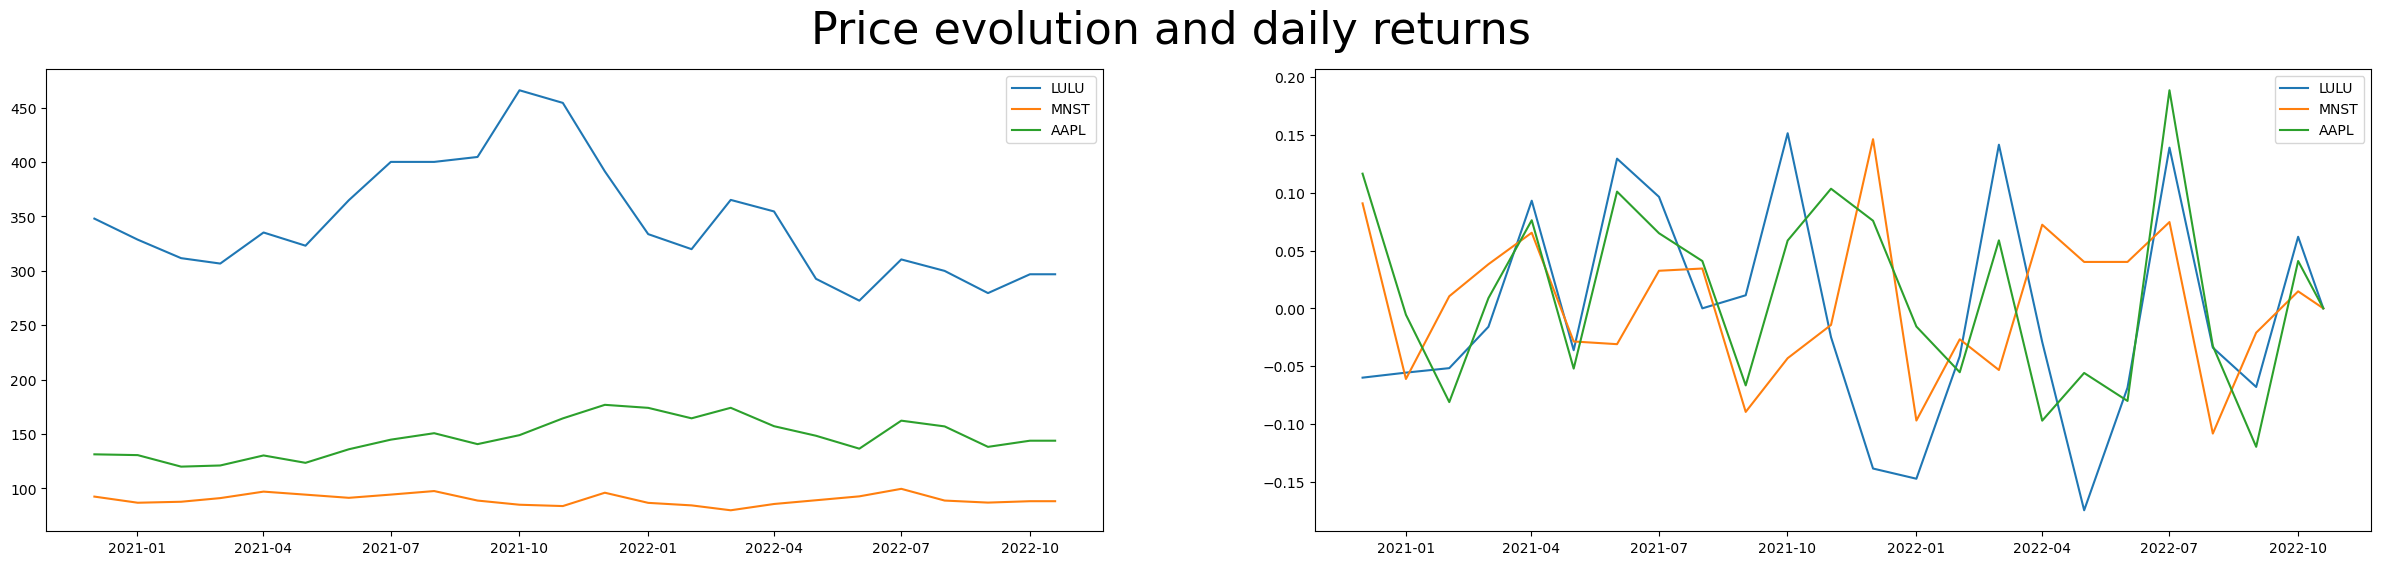

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(30,6))
fig.suptitle('Price evolution and daily returns', fontsize='32')

mult = 1e4

for s in stocks:
  ax[0].plot(df[s])
  ax[1].plot(stock_ret[s])
  print(s)
  print(np.rint(stock_ret[s].mean()*mult))
print("COVARIANCE of percentage returns")
print(np.rint(stock_ret.cov()*mult))
  

ax[0].legend(stocks)
ax[1].legend(stocks)

In [10]:
""" fig, ax = plt.subplots(1, 2, figsize=(30,6))
fig.suptitle('Price evolution and daily returns', fontsize='32')

for s in stocks:
  ax[0].plot(df[s])
  ax[1].plot(df[s+"_diff"])
  print(s)
  print(df[s+"_diff"].mean())
print("COVARIANCE of diff returns")
print(df[[s+"_diff" for s in stocks]].cov())
  

ax[0].legend(stocks)
ax[1].legend(stocks) """

' fig, ax = plt.subplots(1, 2, figsize=(30,6))\nfig.suptitle(\'Price evolution and daily returns\', fontsize=\'32\')\n\nfor s in stocks:\n  ax[0].plot(df[s])\n  ax[1].plot(df[s+"_diff"])\n  print(s)\n  print(df[s+"_diff"].mean())\nprint("COVARIANCE of diff returns")\nprint(df[[s+"_diff" for s in stocks]].cov())\n  \n\nax[0].legend(stocks)\nax[1].legend(stocks) '

$$
min_z -\mu^tz + z^t\sigma z \\
s.t. z \in Z^d \\
\sum_i z_i = \frac{1}{p_w}
$$

Now we reformulate the model, using binary variables. In particular the partition is $w = 3$, $p_w = 1/(2^w-1) = 1/7$ and therefore we need 3 binary variables for every integer:

$$
min_z -\Mu^tx + x^t\Sigma x \\
s.t. x \in B^{3d} \\
\sum_i \sum_{j = 0}^2 2^j x_{ij} = 2^w - 1
$$

Binary expansion:
$$
z = \sum_{i = 0}^2 2^i x_i
$$

Where $\Mu$ and $\Sigma$ are the corresponding $\mu$ and $\sigma$ but for binary variables structures


In [4]:
def binary_mapper_PO(n_int, bin_per_int, mu, sigma):
    mu = mu.to_numpy()
    sigma = sigma.to_numpy()
    assert len(mu) == n_int
    n_bin = n_int * bin_per_int
    
    # constraints 
    A = np.array( [2**i for i in range(bin_per_int-1, -1, -1)]*n_int )
    b = 2**bin_per_int - 1
    
    # objective
    scaler = A
    Mu = np.array([[el for i in range(bin_per_int)] for el in mu]).flatten()
    Mu = Mu*scaler

    grid = np.outer(scaler, scaler)
    Sigma = np.ndarray((n_bin, n_bin), dtype=int)
    for i in range(n_int):
        for j in range(n_int):
            Sigma[bin_per_int*i : bin_per_int*(i+1), bin_per_int*j : bin_per_int*(j+1)] = sigma[i,j]
    Sigma = Sigma*grid

    assert len(A) == n_bin
    assert len(Mu) == n_bin
    assert np.shape(Sigma)[0] == n_int * bin_per_int

    return Mu, Sigma, A, b

#binary_mapper_PO(len(stocks), 3, mu, sigma)


In [71]:
### GET not NaN stocks

all_stocks = []

with open('./stocks_screener.csv', 'r') as fold:
    next(fold)
    #i = 0
    #old_best = 0
    for line in fold:
        """ i += 1
        if np.rint(4800/i *10) > old_best:
            old_best = np.rint(4800/i *10)
            print(f"{old_best}0%...\n") """
        if line[2] == ",":
            comma_pos = 2
        elif line[3] == ",":
            comma_pos = 3
        elif line[4] == ",":
            comma_pos = 4
        elif line[5] == ",":
            comma_pos = 5
        elif line[1] == ",":
            comma_pos = 1
        else:
            print("No comma found in this line")
            continue

        stock = line[:comma_pos]
        df = yf.download(stock, period = "2y", interval = "1mo", progress = False)[["Adj Close"]]
        unvalid = np.any( np.isnan(df["Adj Close"]) )
        if not unvalid:
            all_stocks.append(stock)

print(len(all_stocks))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [73]:
# get a subset of total stocks
n_stocks = 800
STOCKS = np.random.choice(all_stocks, size = n_stocks, replace=False)

['FLGC' 'TRON' 'CMPS' 'ENOB' 'UCTT' 'UPTDU' 'RDFN' 'BMBL' 'PTOCW' 'NEOV']
['WINT' 'PRAA' 'AVEO' 'VYGR' 'LMACU' 'GSRMW' 'RFACU' 'BLFY' 'XP' 'SY']


In [ ]:
# get valid_STOCKS from STOCKS (399 out of 800)

frames = []
i = 0
for i in range(len(STOCKS)):
    print(i)
    stock = STOCKS[i]
    df = yf.download(stock, period = "2y", interval = "1mo")[["Adj Close"]]
    df = df.rename({"Adj Close": stock}, axis=1)
    n_invalids = np.sum( np.isnan(df[stock]) )
    if n_invalids <= 4 and len(df[stock]) > 24:
        frames.append(df)

print(f"Collected {len(frames)} frames")
df_valid = pd.concat(frames, axis=1)

### get the names of the valid STOCKS from df_valid
valid_STOCKS = list(df_valid.columns)

In [8]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import OptimizationResultStatus
from docplex.mp.model_reader import ModelReader
from qiskit_optimization.translators import from_docplex_mp
from ds import Problem
import warnings


def build_qp(n, mu, sigma, A, b):
    '''
    Returns a quadratic problem with n decision variable, h and l respectively quadratic and linear 
    part of objective function and A and b matrix and vector corresponding to constraints
    '''
    qp = QuadraticProgram(name='random_problem.lp')
    for i in range(n):
        qp.binary_var()
    # objective function
    qp.minimize(linear = -mu, quadratic = sigma)
    # constraints
    qp.linear_constraint(linear = A, sense = "==", rhs = b)
    return qp


def build_instance(n_int, bin_per_int, test_set, seed = 42, to_file = True):
    '''
    Given the problem size (n_vars and n_cons), create a problem instance, normalize it, check feasibility and write to file
    normalize_method identifies the way in which the instance is generated and normalized. Specifically, BN, SN and NN
    refer to BruteNormalization, SamplingNormalization and NoNormalization, respectively.
    Return:
        p - the problem instance
    '''
    
    np.random.seed(seed)
    # produce instance
    n = bin_per_int * n_int
    # get data with not many NaN from valid_STOCKS for the Tickers and from df_valid for the financial data itself
    my_stocks = np.random.choice(valid_STOCKS, replace = False, size = n_int)

    # get and clean data for stocks
    """ df = [yf.download(stock, period = "2y", interval = "1mo")[["Adj Close"]] for stock in my_stocks]
    for i in range(len(my_stocks)):
        df[i] = df[i].rename({"Adj Close": my_stocks[i]}, axis=1)
    df = pd.concat(df, axis=1) """
    df = df_valid[my_stocks]
    df = df.dropna()
    
    stock_ret = df.pct_change()
    stock_ret = stock_ret.dropna()
    mult = 1e4
    mu = np.rint(stock_ret.mean()*mult).astype(int)
    sigma = np.rint(stock_ret.cov()*mult).astype(int)
    
    # put risk adversion afctor gamma to 0.5
    sigma = (sigma/2).astype(int)

    mu, sigma, A, b = binary_mapper_PO(n_int, bin_per_int, mu, sigma)
    qp = build_qp(n, mu, sigma, A, b)
    p = Problem(qp)

    # test feasibility of instance
    # write
    file = open("test_feasibility.lp", "w")
    file.write(p.qp.export_as_lp_string())
    file.close()
    # read and try to solve
    m = ModelReader.read("test_feasibility.lp", ignore_names=True)
    p_test = Problem(from_docplex_mp(m))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        c_res = p_test.solve_exact()
    if c_res.status != OptimizationResultStatus.SUCCESS:
        print("Infeasible problem, trying another one")
        return build_instance(n_int, bin_per_int, test_set, seed = seed + 1)
    if len(c_res.x) < n:
        print("Problem with less variables, trying another one")
        return build_instance(n_int, bin_per_int, test_set, seed = seed + 1)
    
    # write to LP file
    if to_file:
        filename = f"{test_set}/{n}/random{seed}_{n}.lp"
        p.qp.write_to_lp_file(filename)
        print(f"File {filename} wrote")
    return p



def build_database(test_set, n_instances, n_int, bin_per_int = 3, starting_seed = 42):
    '''
    Write to file n_instances instances of problems to build a database
    '''
    seed = starting_seed
    for i in range(n_instances):
        build_instance(n_int, bin_per_int, test_set, seed = seed)
        seed += 100
    return

In [10]:
test_set = "../toys/PO_part3_ra05"
n_samples = 200
int_vars = np.arange(2,9)

for nvars in int_vars:
    build_database(test_set, n_samples, nvars)

File ../toys/PO_part3_ra05/6/random42_6.lp wrote
File ../toys/PO_part3_ra05/6/random142_6.lp wrote
File ../toys/PO_part3_ra05/6/random242_6.lp wrote
File ../toys/PO_part3_ra05/6/random342_6.lp wrote
File ../toys/PO_part3_ra05/6/random442_6.lp wrote
File ../toys/PO_part3_ra05/6/random542_6.lp wrote
File ../toys/PO_part3_ra05/6/random642_6.lp wrote
File ../toys/PO_part3_ra05/6/random742_6.lp wrote
File ../toys/PO_part3_ra05/6/random842_6.lp wrote
File ../toys/PO_part3_ra05/6/random942_6.lp wrote
File ../toys/PO_part3_ra05/6/random1042_6.lp wrote
File ../toys/PO_part3_ra05/6/random1142_6.lp wrote
File ../toys/PO_part3_ra05/6/random1242_6.lp wrote
File ../toys/PO_part3_ra05/6/random1342_6.lp wrote
File ../toys/PO_part3_ra05/6/random1442_6.lp wrote
File ../toys/PO_part3_ra05/6/random1542_6.lp wrote
File ../toys/PO_part3_ra05/6/random1642_6.lp wrote
File ../toys/PO_part3_ra05/6/random1742_6.lp wrote
File ../toys/PO_part3_ra05/6/random1842_6.lp wrote
File ../toys/PO_part3_ra05/6/random1942_6.

In [2]:
# df_valid.to_csv("./stocks.csv")
df_valid = pd.read_csv("../toys/PO_part3/Stocks_values.csv")

In [7]:
valid_STOCKS = [
    'CMPS', 'ENOB', 'UCTT', 'RDFN', 'NEOV', 'TLSA', 'GIFI', 'LIVE', 'APRE', 'PRLD', 'OPRX', 'FRPT', 'ARVL', 'LVO', 'TMPMU', 'CRUS', 'WVE', 'ANY', 'GAME', 'SYPR', 'MSPR', 'REFR', 'RUBY', 'OMER', 'LPCN', 'LVOX', 'PFX', 'PCRX', 'ICCH', 'MBRX', 'SND', 'PGEN', 'CBAY', 'AFMD', 'WLFC', 'MYGN', 'MDXG', 'LYRA', 'AEMD', 'ERII', 'SNES', 'BLI', 'SGBX', 'BOSC', 'MINM', 'LNW', 'ADPT', 'NUVA', 'LOCO', 'ACEV', 'CAPR', 'AGMH', 'HLIT', 'CTG', 'PAYS', 'WHLRP', 'ADXN', 'JAZZ', 'OGI', 'ALLK', 'BSFC', 'TENX', 'BNGO', 'CERS', 'IMAB', 'EUCRU', 'LRMR', 'MNOV', 'WPRT', 'CDMO', 'DTIL', 'UBX', 'STKS', 'ESPR', 'WDC', 'CNDT', 'OTMO', 'QDEL', 'MTEM', 'RMBS', 'VERI', 'ACET', 'GNFT', 'KIRK', 'CHEF', 'RETA', 'MTLS', 'WDAY', 'VERY', 'EKSO', 'PPIH', 'HROW', 'CMRX', 'EXLS', 'PRPL', 'PDEX', 'PLBY', 'OTIC', 'UGRO', 'VCEL', 'YELL', 'NRIX', 'AFBI', 'LITE', 'NTLA', 'IDXX', 'KVHI', 'FUSN', 'NVEE', 'LWAY', 'PBPB', 'SEAC', 'GRCY', 'MIDD', 'RDI', 'QUMU', 'STKL', 'OM', 'TOMZ', 'CSSE', 'AGBA', 'AXDX', 'HLBZ', 'ARCE', 'CGC', 'CIH', 'AEHL', 'DOMO', 'CDXC', 'NCNO', 'CDAK', 'EZPW', 'CLPT', 'AWRE', 'BLDE', 'SWIR', 'LESL', 'TTCF', 'PLXS', 'QMCO', 'TRMB', 'ATY', 'MRUS', 'BCTX', 'GPRO', 'DSGR', 'CONXU', 'LTRPB', 'KDNY', 'ABUS', 'EH', 'BLFS', 'WLDN', 'NNBR', 'CPRT', 'BIOR', 'QUIK', 'STOK', 'UNAM', 'BSGM', 'FRSX', 'SMCI', 'VWE', 'CIDM', 'SECO', 'FTDR', 'ZIVO', 'SPWH', 'THTX', 'FNKO', 'OBSV', 'RVLP', 'FFIE', 'OMCL', 'LIQT', 'IGACU', 'SMLR', 'QNST', 'OCGN', 'RYTM', 'PLUG', 'TALK', 'CGRN', 'NVNOW', 'KROS', 'XELB', 'RSLS', 'NKLA', 'ALBO', 'KEQU', 'BPTH', 'CNTY', 'QLYS', 'ETNB', 'DSGX', 'BTB', 'WVVI', 'FLNT', 'OPT', 'XTLB', 'FRGI', 'ALIM', 'MTCH', 'KMDA', 'LBTYB', 'SPNE', 'VMD', 'EHTH', 'LBTYA', 'FCUV', 'BTRS', 'PRDO', 'SJ', 'IRBT', 'PHUN', 'SUPN', 'VJET', 'PULM', 'MKTW', 'SRTS', 'FATE', 'ATOS', 'TCOM', 'GOEV', 'DMRC', 'SIFY', 'RAPT', 'LILA', 'APM', 'CKPT', 'GMGI', 'NXTP', 'SNBR', 'URBN', 'BNFT', 'WAVD', 'CABA', 'IPGP', 'GSIT', 'SSYS', 'DENN', 'MDJH', 'CRWD', 'RMCF', 'WKHS', 'KZR', 'VRME', 'OPEN', 'BRID', 'GIGM', 'ECOR', 'INSE', 'MULN', 'XSPA', 'AMST', 'PLYA', 'SILK', 'COMM', 'ALGS', 'TVTX', 'PME', 'APTX', 'EDIT', 'CSII', 'FWP', 'SINT', 'ZBRA', 'FHTX', 'SCWX', 'TREE', 'GIII', 'EVK', 'BLSA', 'PODD', 'MEDP', 'PASG', 'MOXC', 'TLF', 'WIMI', 'IVAC', 'DKNG', 'AQB', 'CVGI', 'EQ', 'YGMZ', 'ZI', 'DCPH', 'CORT', 'BTCY', 'HA', 'PAYO', 'ABCM', 'MARA', 'KIDS', 'ANGH', 'RPTX', 'MAYS', 'GDEN', 'LI', 'DNLI', 'RGNX', 'ALRN', 'BKNG', 'TITN', 'CLOV', 'MHLD', 'HSIC', 'CNCE', 'JAKK', 'LIVN', 'QLGN', 'SDGR', 'CLXT', 'HQY', 'GMTX', 'NTNX', 'ITCI', 'CCXI', 'YI', 'OPTN', 'OFIX', 'CMLS', 'TGTX', 'ANIK', 'RBBN', 'EGLX', 'LASR', 'AEHR', 'CROX', 'ACLS', 'HFFG', 'KURA', 'CHNR', 'SSTI', 'XPEL', 'LEGH', 'FVCB', 'RVNC', 'VSTA', 'AMTX', 'THRM', 'CTRN', 'TBPH', 'AACG', 'AVPT', 'DSKE', 'CVCO', 'MLACU', 'CTMX', 'LWLG', 'EVGN', 'TCX', 'AKAM', 'IONM', 'NTGR', 'EYE', 'MLAC', 'AKUS', 'ARDS', 'DARE', 'MDWD', 'ISUN', 'DISH', 'OMQS', 'ALT', 'GLPG', 'XAIR', 'VERU', 'LOPE', 'MASI', 'SMTI', 'CAAS', 'CTHR', 'OSUR', 'FIXX', 'GSMG', 'LQDA', 'FOCS', 'PRPO', 'ORTX', 'RLAY', 'ALVR', 'ZTEK', 'RWLK', 'RIGL', 'TRVN', 'MRTX', 'GT', 'GLRE', 'TCRR', 'SMTC', 'WTER', 'PHIO', 'WINT', 'PRAA', 'AVEO', 'VYGR', 'XP', 'SY'
]
print(len(valid_STOCKS))

399
